In [1]:
%load_ext autoreload
%autoreload 2

from krxns.config import filepaths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import torch
from pathlib import Path

In [2]:
def latest_ckpt(ckpt_dir: Path):
    ckpts = list(ckpt_dir.glob("*.ckpt"))
    ckpt_rank = [tuple([elt.split("=")[-1] for elt in ckpt.stem.split("-")]) for ckpt in ckpts]
    srt_ckpts = sorted(zip(ckpt_rank, ckpts), key=lambda x : x[0], reverse=True)
    return srt_ckpts[0][1]

In [3]:
# Set this
experiment = "default_chemprop_data_titration_w_self_paths"
copts = [elt.stem for elt in  (filepaths["spl_cv"] / experiment).glob('*')]


In [4]:
# Loss curves
def plot_loss_curves(experiment=experiment, condition=copts, upto=100):
    lc = []
    cond_dir = filepaths["spl_cv"] / experiment / condition

    for fp in cond_dir.glob("split_*/metrics.csv"):
        ckpt = latest_ckpt(fp.parent / "checkpoints")
        state_dict = torch.load(ckpt, map_location=torch.device('cpu'))
        scl = float(state_dict['hyper_parameters']['predictor']['output_transform'].scale)
        split = pd.read_csv(fp, sep=',')
        split['split'] = int(fp.parent.stem.split('_')[-1])
        lc.append(split)

    stats = ('mean', 'std')
    lc = pd.concat(lc, axis=0).drop(columns=['step', 'train_loss_epoch'])
    lc = lc.groupby(['epoch', 'split']).agg('mean').reset_index() # Average over epochs w/in splits
    lc['val/rmse_rescaled'] = lc['val/rmse'] * scl # Add re-scaled rmse
    lc = lc.groupby('epoch').agg(stats).drop(columns=['split']).reset_index() # Average over epochs across splits
    
    fig, ax = plt.subplots(nrows=2, figsize=(7, 8), sharex=True)
    metrics, _ = zip(*lc.columns)
    metrics = set(filter(lambda x : x not in ['epoch', 'val/rmse_rescaled'], metrics))
    for m in metrics:
        print(f"Min {m}: {lc[(m, stats[0])].min()}")
        ax[1].errorbar(x=lc['epoch'][:upto], y=lc[(m, stats[0])][:upto], yerr=lc[(m, stats[1])][:upto], label=m)

    print(f"Min {'val/rmse_rescaled'}: {lc[('val/rmse_rescaled', stats[0])].min()}")
    ax[0].errorbar(x=lc['epoch'][:upto], y=lc[('val/rmse_rescaled', stats[0])][:upto], yerr=lc[('val/rmse_rescaled', stats[1])][:upto])

    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    ax[0].set_ylabel("Rescaled RMSE [synthetic distance]")
    plt.show()

In [ ]:
interact(plot_loss_curves)

interactive(children=(Text(value='default_chemprop_data_titration_w_self_paths', description='experiment'), Dr…

<function __main__.plot_loss_curves(experiment='default_chemprop_data_titration_w_self_paths', condition=['10_chunks', '20_chunks', '5_chunks', '40_chunks', '1_chunks'], upto=100)>

Min train_loss_step: 0.023519013436245018
Min val_loss: 0.12964872717857362
Min val/rmse: 0.3600391089916229
Min val/mae: 0.2491011291742325
Min val/rmse_rescaled: 1.6066953314942167


/tmp/ipykernel_172388/2384897239.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, map_location=torch.device('cpu'))
/tmp/ipykernel_172388/23

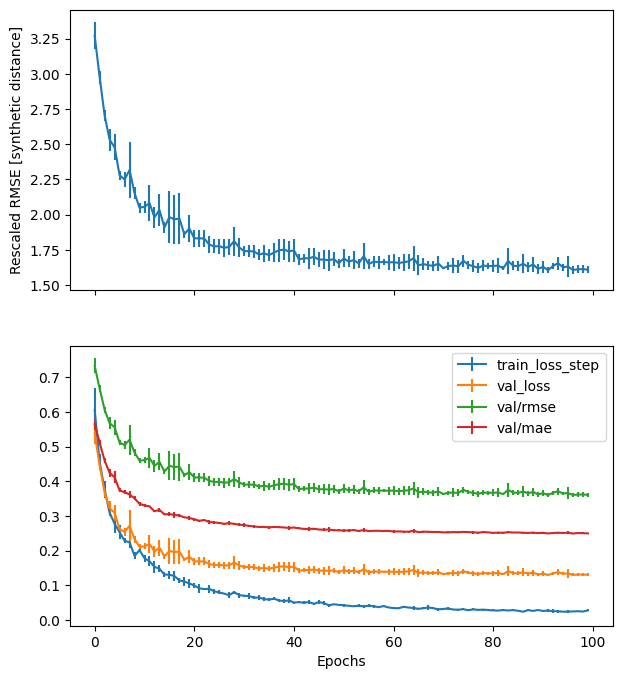

/tmp/ipykernel_172388/2384897239.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, map_location=torch.device('cpu'))
/tmp/ipykernel_172388/23

Min train_loss_step: 0.023622325954160472
Min val_loss: 0.09853125512599942
Min val/rmse: 0.31383092403411866
Min val/mae: 0.19858579337596893
Min val/rmse_rescaled: 1.4004886356272663


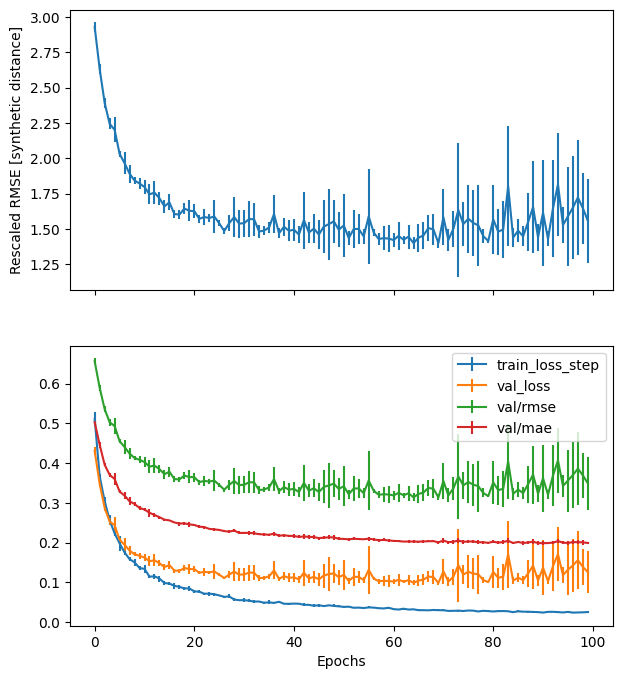

/tmp/ipykernel_172388/2384897239.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, map_location=torch.device('cpu'))
/tmp/ipykernel_172388/23

Min train_loss_step: 0.020509248599410012
Min val_loss: 0.18705778717994687
Min val/rmse: 0.4324140608310699
Min val/mae: 0.3067733347415924
Min val/rmse_rescaled: 1.929672736818992


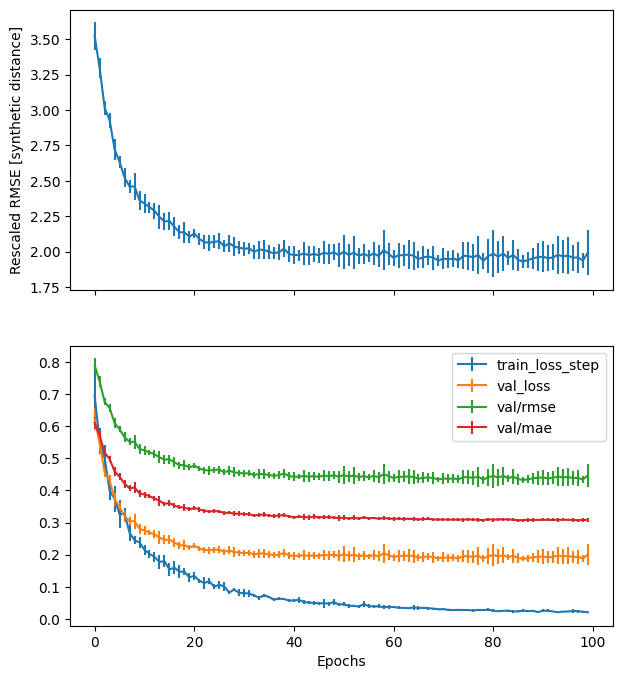

/tmp/ipykernel_172388/2384897239.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, map_location=torch.device('cpu'))
/tmp/ipykernel_172388/23

Min train_loss_step: 0.02252814080566163
Min val_loss: 0.11261489540338512
Min val/rmse: 0.3353787779808044
Min val/mae: 0.1694346666336059
Min val/rmse_rescaled: 1.496643980750957


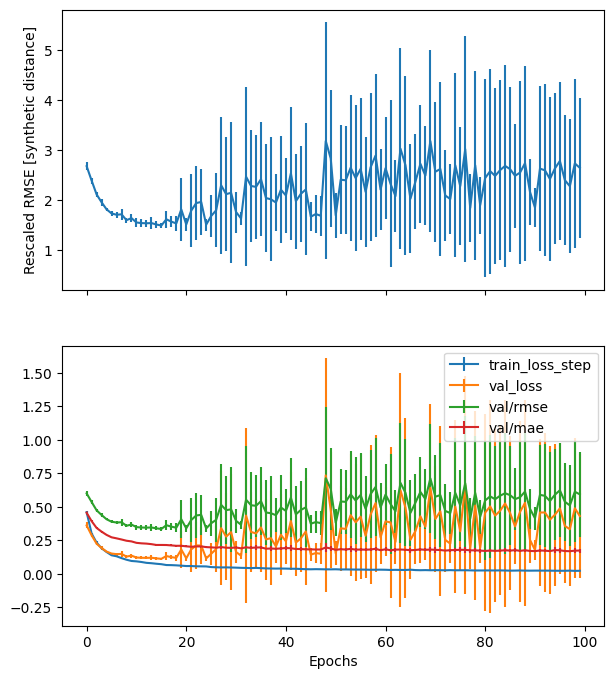

/tmp/ipykernel_172388/2384897239.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, map_location=torch.device('cpu'))
/tmp/ipykernel_172388/23

Min train_loss_step: 0.01960282111540432
Min val_loss: 0.41337531208992007
Min val/rmse: 0.6421498656272888
Min val/mae: 0.4820914328098297
Min val/rmse_rescaled: 2.8644691606335755


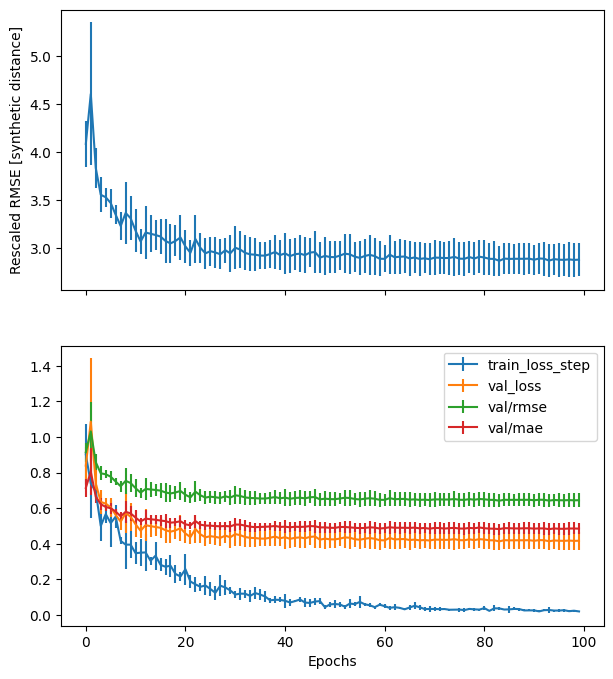

In [6]:
for c in copts:
    plot_loss_curves(condition=c)

/tmp/ipykernel_172388/4047061897.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, map_location=torch.device('cpu'))
/tmp/ipykernel_172388/40

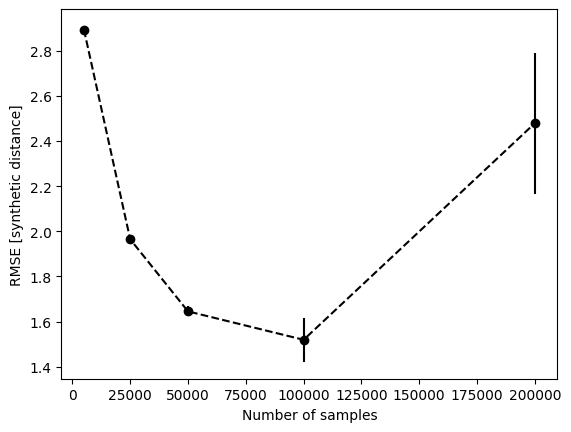

In [7]:
def plot_data_scaling(condition, discard: int = 50, experiment=experiment):
    lc = []
    cond_dir = filepaths["spl_cv"] / experiment / condition

    for fp in cond_dir.glob("split_*/metrics.csv"):
        ckpt = latest_ckpt(fp.parent / "checkpoints")
        state_dict = torch.load(ckpt, map_location=torch.device('cpu'))
        scl = float(state_dict['hyper_parameters']['predictor']['output_transform'].scale)
        split = pd.read_csv(fp, sep=',')
        split['split'] = int(fp.parent.stem.split('_')[-1])
        lc.append(split)

    stats = ('mean', 'std')
    lc = pd.concat(lc, axis=0).drop(columns=['step', 'train_loss_epoch'])
    lc = lc.groupby(['epoch', 'split']).agg('mean').reset_index() # Average over epochs w/in splits
    lc['val/rmse_rescaled'] = lc['val/rmse'] * scl # Add re-scaled rmse
    lc = lc.groupby('epoch').agg(stats).drop(columns=['split']).reset_index() # Average over epochs across splits
    ss_val_rmse = lc.loc[discard:, ('val/rmse_rescaled', 'mean')].to_numpy()
    return (ss_val_rmse.mean(), ss_val_rmse.std())

data_sz = [int(elt.split('_')[0]) * 5_000 for elt in copts]
trace = []
for c in copts:
    trace.append(plot_data_scaling(c))

x, y = zip(*sorted(zip(data_sz, trace), key=lambda x : x[0]))
mu, std = zip(*y)
fig, ax = plt.subplots()
ax.errorbar(x, mu, std, linestyle='--', marker='o', color='black')
ax.set_xlabel('Number of samples')
ax.set_ylabel("RMSE [synthetic distance]")
plt.show()